In [21]:
from PIL import Image as Im
import matplotlib.pyplot as plt
import numpy as np

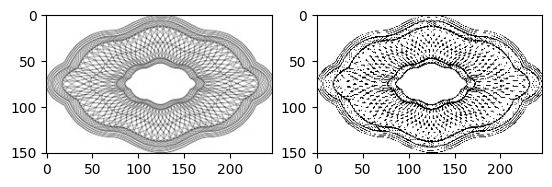

In [27]:
wm = Im.open("lab6/WM.png")
img = Im.open("lab6/InputImage.png")
m1, n1 = img.size
img_g = Im.Image.convert(img, "L")
wm_g = Im.Image.convert(wm, "L")
m2, n2 = wm.size
m = min(m1, m2)
n = min(n1, n2)
fig, [ax1, ax2] = plt.subplots(1, 2)

wm_array = np.array(wm_g, dtype=np.double)
img_array = np.array(img_g)

ax1.imshow(Im.fromarray(wm_array), cmap="gray")
wm_array = ((wm_array - np.min(np.min(wm_array))) / (np.max(np.max(wm_array)) - np.min(np.min(wm_array)))) * 255
wm_array[wm_array > 127] = 255
wm_array[wm_array <= 127] = 0
ax2.imshow(Im.fromarray(wm_array), cmap="gray")
img_fragment = img_array[:m, :n]
wm_fragment = wm_array[:m, :n]